# 8.5. 循环神经网络的从零开始实现

In [1]:
%matplotlib inline
import math
import torch
from torch import nn
from torch.nn import functional as F
from d2l import torch as d2l

batch_size, num_steps = 32, 35
train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [2]:
len(vocab)

28

# 8.5.1. 独热编码

In [3]:
F.one_hot(torch.tensor([0, 2]), len(vocab))

tensor([[1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0],
        [0, 0, 1, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0]])

In [4]:
X = torch.arange(10).reshape((2, 5))
F.one_hot(X.T, 28).shape

torch.Size([5, 2, 28])

# 8.5.2. 初始化模型参数

In [5]:
def get_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = vocab_size

    def normal(shape):
        return torch.randn(size=shape, device=device)

    # 隐藏层参数
    W_xh = normal((num_inputs, num_hiddens))
    W_hh = normal((num_hiddens, num_hiddens))
    b_h = torch.zeros(num_hiddens, device=device)
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xh, W_hh, b_h, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

# 8.5.3. 循环神经网络模型

In [6]:
# 在初始化时返回隐状态。 这个函数的返回是一个张量，张量全用0填充， 形状为（批量大小，隐藏单元数）
def init_rnn_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device), )

In [7]:
# 前向函数
def rnn(inputs, state, params):
    # inputs的形状：(时间步数量，批量大小，词表大小)
    W_xh, W_hh, b_h, W_hq, b_q = params
    H, = state
    outputs = []
    # X的形状：(批量大小，词表大小)
    for X in inputs:
        H = torch.tanh(torch.mm(X, W_xh) + torch.mm(H, W_hh) + b_h)
        Y = torch.mm(H, W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H,)

In [8]:
class RNNModelScratch: #@save
    """从零开始实现的循环神经网络模型"""
    # 词表大小，隐藏单元数，设备，参数初始化，初始状态，前向函数
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn
    
    # 转换输入X的维度，获得形状为 （时间步数，批量大小，词表大小）的输出(转制后独热编码), 之后计算前向传播函数forward_fn
    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    # 在初始化时返回隐状态。 这个函数的返回是一个张量，张量全用0填充， 形状为（批量大小，隐藏单元数）
    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [9]:
num_hiddens = 512
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
state = net.begin_state(X.shape[0], d2l.try_gpu())   # 在初始化时返回隐状态
Y, new_state = net(X.to(d2l.try_gpu()), state)       # 计算Y
Y.shape, len(new_state), new_state[0].shape

(torch.Size([10, 28]), 1, torch.Size([2, 512]))

# 8.5.4. 预测

In [12]:
def predict_ch8(prefix, num_preds, net, vocab, device):  #@save
    """在prefix后面生成新字符"""
    state = net.begin_state(batch_size=1, device=device)     # 在初始化时返回隐状态
    # 计算outputs: prefix预热期更新隐状态但不会进行预测, 后预测num_preds步
    outputs = [vocab[prefix[0]]]
    get_input = lambda: torch.tensor([outputs[-1]], device=device).reshape((1, 1))   # 上一个的输出作为下一个的输入 函数
    # 1-预热期: 模型会自我更新（例如，更新隐状态）， 但不会进行预测
    for y in prefix[1:]:
        _, state = net(get_input(), state)
        outputs.append(vocab[y])
    # 2-预测num_preds步
    for _ in range(num_preds):
        y, state = net(get_input(), state)
        outputs.append(int(y.argmax(dim=1).reshape(1)))
    return ''.join([vocab.idx_to_token[i] for i in outputs])

In [13]:
predict_ch8('time traveller ', 10, net, vocab, d2l.try_gpu())

'time traveller pxhqsjjxti'

# 8.5.5. 梯度裁剪

对于长度为T的序列，我们在迭代中计算这T个时间步上的梯度， 将会在反向传播过程中产生长度为O(T)的矩阵乘法链。 如 4.8节所述， 当T较大时，它可能导致数值不稳定， 例如可能导致梯度爆炸或梯度消失。 因此，循环神经网络模型往往需要额外的方式来支持稳定训练。  
下面的裁剪函数，使得梯度过大时，将梯度投影回给定半径（例如theta）的球来裁剪：g = min(1, theta / ||params||) * g

In [14]:
def grad_clipping(net, theta):  #@save
    """裁剪梯度"""
    if isinstance(net, nn.Module):
        params = [p for p in net.parameters() if p.requires_grad]
    else:
        params = net.params
    norm = torch.sqrt(sum(torch.sum((p.grad ** 2)) for p in params))
    if norm > theta:
        for param in params:
            param.grad[:] *= theta / norm

# 8.5.6. 训练

在训练模型之前，让我们定义一个函数在一个迭代周期内训练模型。 它与我们训练 3.6节模型的方式有三个不同之处。

> 1. 序列数据的不同采样方法（随机采样和顺序分区）将导致隐状态初始化的差异。
> 2. 我们在更新模型参数之前裁剪梯度。 这样的操作的目的是，即使训练过程中某个点上发生了梯度爆炸，也能保证模型不会发散。 
> 3. 我们用困惑度来评价模型。如 8.4.4节所述， 这样的度量确保了不同长度的序列具有可比性。

In [15]:
#@save
def train_epoch_ch8(net, train_iter, loss, updater, device, use_random_iter):
    """训练网络一个迭代周期（定义见第8章）"""
    state, timer = None, d2l.Timer()
    metric = d2l.Accumulator(2)  # 训练损失之和,词元数量
    for X, Y in train_iter:
        # 隐状态初始化
        if state is None or use_random_iter:
            # 在第一次迭代或使用随机抽样时初始化state
            state = net.begin_state(batch_size=X.shape[0], device=device)
        else:
            if isinstance(net, nn.Module) and not isinstance(state, tuple):
                # state对于nn.GRU是个张量
                state.detach_()
            else:
                # state对于nn.LSTM或对于我们从零开始实现的模型是个张量
                for s in state:
                    s.detach_()
        # 迭代更新
        y = Y.T.reshape(-1)
        X, y = X.to(device), y.to(device)
        y_hat, state = net(X, state)
        l = loss(y_hat, y.long()).mean()
        if isinstance(updater, torch.optim.Optimizer):
            updater.zero_grad()
            l.backward()
            grad_clipping(net, 1)
            updater.step()
        else:
            l.backward()
            grad_clipping(net, 1)
            # 因为已经调用了mean函数
            updater(batch_size=1)
        # 保存损失
        metric.add(l * y.numel(), y.numel())
    return math.exp(metric[0] / metric[1]), metric[1] / timer.stop()

In [16]:
#@save
def train_ch8(net, train_iter, vocab, lr, num_epochs, device,
              use_random_iter=False):
    """训练模型（定义见第8章）"""
    loss = nn.CrossEntropyLoss()
    animator = d2l.Animator(xlabel='epoch', ylabel='perplexity',
                            legend=['train'], xlim=[10, num_epochs])
    # 初始化
    if isinstance(net, nn.Module):
        updater = torch.optim.SGD(net.parameters(), lr)
    else:
        updater = lambda batch_size: d2l.sgd(net.params, lr, batch_size)
    predict = lambda prefix: predict_ch8(prefix, 50, net, vocab, device)
    # 训练和预测
    for epoch in range(num_epochs):
        ppl, speed = train_epoch_ch8(
            net, train_iter, loss, updater, device, use_random_iter)
        if (epoch + 1) % 10 == 0:
            print(predict('time traveller'))
            animator.add(epoch + 1, [ppl])
    print(f'困惑度 {ppl:.1f}, {speed:.1f} 词元/秒 {str(device)}')
    print(predict('time traveller'))
    print(predict('traveller'))

困惑度 16824916944915247104.0, 115181.5 词元/秒 cuda:0
time travellergrvhcaszjznoiv sosvv<unk>incoagklcmnqomezbrv ohfradmwp
travellersndsoijavunlm zlkqwqcffcmrzgayyvjgtouejygmknggtykj


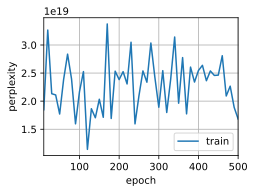

In [19]:
num_epochs, lr = 500, 1
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu())

困惑度 14924797291281711104.0, 91427.0 词元/秒 cuda:0
time travellerxxomo ldgrze dzimjqkqwddlrf  q  rpuhokwdk<unk>uclfqxjp
travellermfswymnygdfrydkthmpxhpo johaylww uucouqwojvapmzlxj


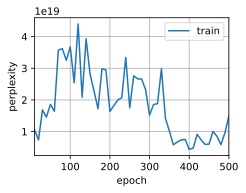

In [20]:
net = RNNModelScratch(len(vocab), num_hiddens, d2l.try_gpu(), get_params,
                      init_rnn_state, rnn)
train_ch8(net, train_iter, vocab, lr, num_epochs, d2l.try_gpu(),
          use_random_iter=True)

# 8.5.7. 小结

- 我们可以训练一个基于循环神经网络的字符级语言模型，根据用户提供的文本的前缀生成后续文本。

- 一个简单的循环神经网络语言模型包括输入编码、循环神经网络模型和输出生成。

- 循环神经网络模型在训练以前需要初始化状态，不过随机抽样和顺序划分使用初始化方法不同。

- 当使用顺序划分时，我们需要分离梯度以减少计算量。

- 在进行任何预测之前，模型通过预热期进行自我更新（例如，获得比初始值更好的隐状态）。

- 梯度裁剪可以防止梯度爆炸，但不能应对梯度消失。

# 8.5.8. 练习